In [1]:
import sys
import numpy as np
from sklearn.model_selection import train_test_split
sys.path.insert(0, 'utilities')
import util

## read in modeling data
nbrhd_size = 1
preprocessed = False
# Species ccurrence locations
occurrences_fns = ['data/empidonax_virescens_19_M1.npz',\
                   'data/empidonax_virescens_19_M2.npz',\
                   'data/empidonax_virescens_19_M3.npz']
# Background locations
background_fns = ['data/empidonax_asr1_bkgnd_hull_19_M1.npz',\
                  'data/empidonax_asr1_bkgnd_hull_19_M2.npz',\
                  'data/empidonax_asr1_bkgnd_hull_19_M3.npz']

# Covariates stats
cov_stats_fn = 'data/covs_stats.csv'
cov_config_fn = 'data/covs_config.json'

coords, data = util.read_data_modeling_cnn(occurrences_fns, background_fns, nbrhd_size, preprocessed, cov_stats_fn, cov_config_fn)
print('modeling data matrix shape:', data.shape)

## data split: train, validation, test
tr_ratio, eval_ratio, te_ratio = 0.8, 0.1, 0.1

coords_tr, train, coords_te, test = util.train_test_split_with_coords(coords, data, test_size=te_ratio)
coords_tr, train, coords_eval, evaluation = util.train_test_split_with_coords(coords_tr, train, test_size=eval_ratio/(1.0-te_ratio))

print('train: %d, evaluation: %d, test: %d' % (len(train), len(evaluation), len(test)))

Python version: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:18:16) [MSC v.1916 64 bit (AMD64)]
modeling data matrix shape: (2084, 152, 1, 1)
train: 1666, evaluation: 209, test: 209


In [2]:
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
import numpy as np

## copy data to gpu
train_gpu = nd.array(train).as_in_context(util.try_gpu(0))
evaluation_gpu = nd.array(evaluation).as_in_context(util.try_gpu(0))
test_gpu = nd.array(test).as_in_context(util.try_gpu(0))

tr_batch_size, eval_batch_size, num_epochs = 100, 100, 100
train_iter = util.get_data_iterator_cnn(train_gpu, batch_size = tr_batch_size)
eval_iter = util.get_data_iterator_cnn(evaluation_gpu, batch_size = eval_batch_size)


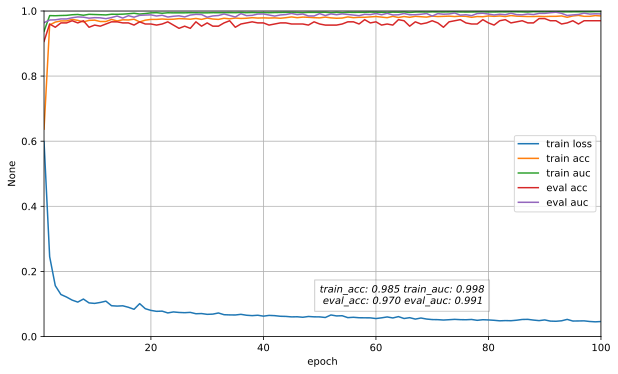

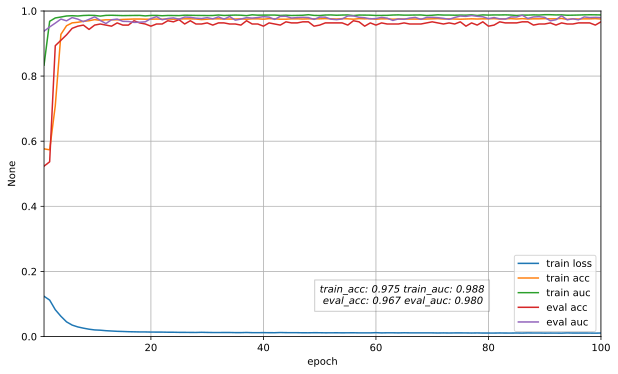

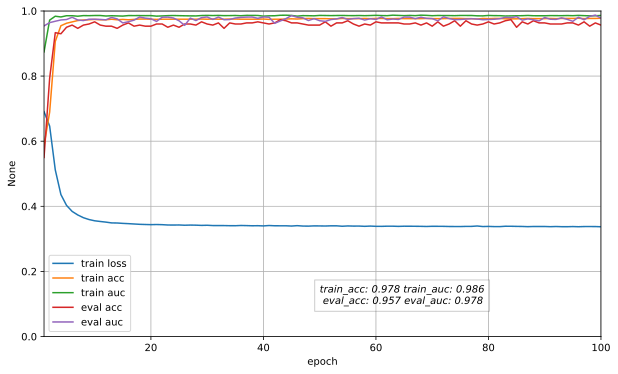

In [3]:
for loss in [gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=True),
             gluon.loss.L2Loss(),\
             gluon.loss.SoftmaxCrossEntropyLoss()]: # works with two net outputs:
    
    drop_prob1, drop_prob2 = 0.2, 0.5
    net = nn.Sequential()
    
    if isinstance(loss, gluon.loss.SoftmaxCrossEntropyLoss): # works with two net outputs

        net.add(#nn.Dense(20, activation='relu'), #'relu'
                nn.Dense(10, activation='relu'),
                #nn.Dropout(drop_prob1),
                #n.Dense(5, activation='relu'),
                #nn.Dropout(drop_prob2),
                nn.Dense(2, activation='sigmoid'))
    else: # works with only one net output
          # from_sigmoid=True because net output already has a sigmoid activiation
        
        net.add(#nn.Dense(20, activation='relu'), #'relu'
                nn.Dense(10, activation='relu'),
                #nn.Dropout(drop_prob1),
                #n.Dense(5, activation='relu'),
                #nn.Dropout(drop_prob2),
                nn.Dense(1, activation='sigmoid'))
    
    ## initialize net parameters on gpu
    net.initialize(init.Normal(sigma=0.01), ctx=util.try_gpu(0))

    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1}) #, 'wd': 1
    util.train_net(net, train_iter, eval_iter, loss, num_epochs, trainer, figfn='output/progress_nn_gpu_' + loss.name + '.png')
